In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
%matplotlib inline
import matplotlib.pyplot as plt
from rtree import index

#import models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
#from xgboost import XGBRegressor

from sklearn import model_selection
from sklearn.metrics import explained_variance_score
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from tabulate import _table_formats, tabulate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import pygad
import time
import datetime

from sklearn import metrics

In [2]:
# datas = '../MyData.xlsx'
datas = '/Users/pkrok/OneDrive/Python/Giannakopoulos/MyData.xlsx'
# datas = '/Users/panagiotiskrokidas/OneDrive/Python/Giannakopoulos/MyData.xlsx'

In [3]:
pd.set_option("display.max_columns", None)
df=pd.read_excel(datas)
df.head(2)
df['logD'] = np.log10(df['diffusivity'])
# df = df.dropna()
# df[df.gas == 'propylene']['logD'].max()
df[df.gas == 'ethylene']['logD'].count()

68

# Keep only the columns I need

In [4]:
# df2=df[[ 'aperture', 'size - van der Waals (Å)','mass', 'ascentricF', 'logD', 'size - kinetic diameter (Å)', 'gas', 'apertureAtom_e', 'ionicRad']]
df2=df[[ 'type', 'gas', 'aperture', 'size - van der Waals (Å)','mass', 'ascentricF', 'logD', 'size - kinetic diameter (Å)', 'ionicRad', 
       'Μ-N_lff', 'Μ-N_kFF', 'MetalCharge',
       'apertureAtom_σ', 'apertureAtom_e', 'linker_length1', 'linker_length2',
       'linker_length3', 'linker_mass1', 'linker_mass2', 'linker_mass3',
       'func1_length', 'func2_length', 'func3_length', 'func1_mass',  
       'func2_mass', 'func3_mass', 'func1_charge', 'func2_charge',
       'func3_charge',]]

In [5]:
df2=df2.rename(columns={'size - van der Waals (Å)':'diameter', 'size - kinetic diameter (Å)':'kdiameter', 'apertureAtom_e':'e' })

In [6]:
df2 = df2.dropna()
df2=df2.reset_index(drop=True)
# df2

## CO2 dataframe

In [7]:
dfco2=df2[(df2['diameter'] == 3.24)].reset_index()
dfco2=dfco2.drop(columns=['index'])
# dfco2

In [8]:
dfch4=df2[(df2['diameter'] == 3.25)].reset_index()
dfch4=dfch4.drop(columns=['index'])
# dfch4

## ML models

In [9]:
regr = linear_model.LinearRegression()
tree=DecisionTreeRegressor(max_depth=5,random_state=1)
print(regr)

LinearRegression()


# ga_instance.plot_genes()

## Add more descriptors

## Model with only metal, aperture_e, lengths of linker1&3 and functional1&3

In [10]:
x_co2 = np.asanyarray(dfco2[[
                          # 'diameter', 
                          'ionicRad',
                          # 'apertureAtom_σ',
                          'linker_length1', 'linker_length2', 'linker_length3',
                          'func1_length', 'func2_length', 'func3_length' ]])


y_co2 = np.array(dfco2[['logD']])

x_ch4 = np.asanyarray(dfch4[[
                          # 'diameter', 
                          'ionicRad',
                          # 'apertureAtom_σ',
                          'linker_length1', 'linker_length2','linker_length3',
                          'func1_length', 'func2_length','func3_length' ]])


y_ch4 = np.array(dfch4[['logD']])

In [11]:
XGBR1 = XGBRegressor(n_estimators=400, max_depth=4, eta=0.02, subsample=1, colsample_bytree=0.7)
XGBR2 = XGBRegressor(n_estimators=200, max_depth=4, eta=0.02, subsample=1, colsample_bytree=0.5)
# XRegr = XGBR.fit(x_train, y_train)
co2 = XGBR1.fit(x_co2, y_co2)
ch4 = XGBR2.fit(x_ch4, y_ch4)

predictionch4=ch4.predict([[ 71.0,	4.86,	3.660,	3.927,	2.700]])
predictionco2=co2.predict([[ 71.0,	4.86,	3.660,	3.927,	2.700]])

print(predictionco2)
print(predictionch4)

[-8.519276]
[-9.423806]


## Set up my GA

In [12]:
def fitness(solution, solution_idx):
    floatResult1 = abs(co2.predict([solution])[0] + 12)
    floatResult2 = abs(co2.predict([solution])[0] - ch4.predict([solution])[0] - 2)
    # return 1.0 - (abs(floatResult - 2) + 10e-10)
    return 1.0 - ((floatResult1*floatResult2) + 10e-10)

In [13]:
fitness_function = fitness

num_generations = 20 # 2000, 12000
num_parents_mating = 10 # 20,  22
 
mutation_probability = [0.5, 0.02] # originally [0.4, 0.01]
mutation_type = "adaptive" # random, swap, inversion, scramble, adaptive

initial_population = x_co2[0:70]

gene_space =  [
              [41, 71, 72, 74, 80],
              [3.66, 4.438, 4.86, 5.7, 6.01, 6.41],
              [3.66, 4.438, 4.86, 5.7, 6.01, 6.41],
              [3.66, 4.438, 4.86, 5.7, 5.996, 6.01, 6.41],
              [2.278, 3.54, 3.78, 3.85, 3.927, 4.093],
              [2.278, 3.54, 3.78, 3.85, 3.927, 4.093],
              [2.278, 2.7, 3.54, 3.78, 3.85, 3.927, 4.093, 4.25],
              ]

parent_selection_type = "tournament" #  "sss", "rws", "tournament", "rank", "random"
K_tournament = 14 #12
keep_parents = 2 # 4, 5

crossover_type = "uniform" # single_point, two_points, uniform, scattered
crossover_probability = 0.7

In [14]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       initial_population = initial_population, 
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type, 
                       # mutation_num_genes = mutation_num_genes,
                       gene_space = gene_space,
                       # sol_per_pop = sol_per_pop,
                       # num_genes = num_genes,
                       crossover_probability = crossover_probability,
                       mutation_probability = mutation_probability,
                       K_tournament = K_tournament,
                       allow_duplicate_genes=False,
                       # stop_criteria = "reach_100",
                       # stop_criteria=["reach_127.4", "saturate_160"],
                       save_solutions=True,
                       save_best_solutions=True
                      )

C:\Users\pkrok\anaconda3\lib\site-packages\pygad\pygad.py:787: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")
C:\Users\pkrok\anaconda3\lib\site-packages\pygad\pygad.py:795: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


# Single run

In [15]:
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-04-05 13:57:53


In [16]:
start_time = time.time()
ga_instance.run()
print("--- %s minutes ---" % ((time.time() - start_time)/60))

--- 0.17499282360076904 minutes ---


In [17]:
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-04-05 13:58:07


In [18]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

predictionco2 = co2.predict([solution])[0]
predictionch4 = ch4.predict([solution])[0]

print(predictionco2)
print(predictionch4)

In [22]:
solution

array([74.   ,  4.438,  6.41 ,  5.996,  3.54 ,  3.85 ,  3.927])

In [397]:
ch4.predict([[71.0,	4.438,	6.010,	5.996,	3.927, 3.927, 3.850]])

array([-12.494662], dtype=float32)

In [398]:
dfSol=pd.DataFrame(data = ga_instance.best_solutions)
dfSol.shape

(2001, 7)

In [402]:
dfSol2=dfSol.drop_duplicates(keep='last')
dfSol3 = dfSol2.reset_index()
dfSol3 = dfSol3.drop(columns=['index'])
dfSol3

,0,1,2,3,4,5,6
0,92.0,4.438,4.438,5.996,3.780,3.780,4.25
1,80.0,4.860,4.860,5.996,3.780,3.780,3.85
2,72.0,4.438,6.410,5.996,3.780,4.093,4.25
3,72.0,4.438,6.410,5.996,2.278,4.093,4.25
4,71.0,3.660,4.438,6.410,3.540,3.850,4.25
...,...,...,...,...,...,...,...
163,74.0,3.660,4.860,6.010,2.278,4.093,4.25
164,74.0,3.660,4.860,6.010,3.780,4.093,4.25
165,74.0,4.438,4.860,6.010,3.540,3.927,3.78
166,74.0,3.660,4.860,6.010,3.540,4.093,4.25


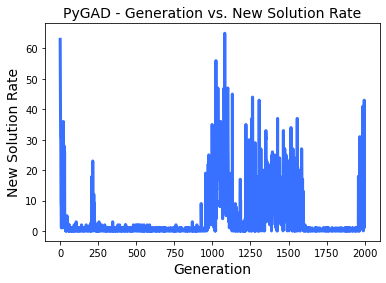

Figure(432x288)


In [400]:
print(ga_instance.plot_new_solution_rate())

In [389]:
# FiveBest = list()

In [404]:
dfSol4 = dfSol3.tail(50)
# dfSol4 = dfSol4.drop(columns=['index'])
solutions = np.asanyarray(dfSol4)
FiveBest.extend(solutions)
FiveBest
dfFiveBest=pd.DataFrame(data = FiveBest)
dfFiveBest

,0,1,2,3,4,5,6
0,92.0,3.660,5.70,5.996,3.780,3.850,3.540
1,92.0,4.438,5.70,5.996,3.780,4.093,3.540
2,74.0,4.438,6.01,5.996,3.780,4.093,4.093
3,74.0,4.438,5.70,5.996,3.780,2.278,4.093
4,74.0,4.438,5.70,5.996,3.780,4.093,4.093
...,...,...,...,...,...,...,...
145,74.0,3.660,4.86,6.010,2.278,4.093,4.250
146,74.0,3.660,4.86,6.010,3.780,4.093,4.250
147,74.0,4.438,4.86,6.010,3.540,3.927,3.780
148,74.0,3.660,4.86,6.010,3.540,4.093,4.250


# Loop for GA

In [410]:
start_time = time.time()

FiveBest = list()

for i in range(2):
    ga_instance.run()
    
    # solution, solution_fitness, solution_idx = ga_instance.best_solution()
    # prediction = XRegr.predict([solution])[0]
    Sol=pd.DataFrame(data = ga_instance.best_solutions)
    Sol2=Sol.drop_duplicates(keep='last')
    Sol3 = Sol2.reset_index()
    # Sol4 = Sol3.tail(20)
    Sol3 = Sol3.drop(columns=['index'])
    # Sol4 = Sol3.tail(20)
    solutions = np.asanyarray(Sol3)
    FiveBest.extend(solutions)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

--- 28.535487735271452 minutes ---


In [447]:
dfFiveBest=pd.DataFrame(data = FiveBest)
# dfFiveBest.loc[29]
# dfFiveBest.loc[41]
dfFiveBest

,0,1,2,3,4,5,6
0,74.0,3.660,4.86,6.01,3.540,3.850,4.25
1,74.0,3.660,4.86,6.01,4.093,3.927,4.25
2,74.0,3.660,4.86,6.01,3.780,4.093,4.25
3,80.0,5.700,4.86,6.01,3.540,3.927,4.25
4,74.0,3.660,4.86,6.01,3.540,4.093,4.25
...,...,...,...,...,...,...,...
148,80.0,3.660,4.86,6.41,3.850,2.278,2.70
149,80.0,4.438,4.86,6.41,2.278,3.540,2.70
150,80.0,3.660,3.66,6.41,4.093,3.540,2.70
151,80.0,3.660,4.86,6.41,4.093,2.278,2.70


In [193]:
# TheData = dfFiveBest
# TheData.rename(columns={"0": "metal", "1": "link1", "2": "link2", "3": "link3", "4": "func1", "5": "func2", "6": "func3"})
# TheData.columns = ["metal", "link1", "link2", "link3", "func1", "func2", "func3"]
# TheData


# RTree

## create dataframe with ratios

In [35]:
dfRatios = pd.DataFrame(columns = ['type', 'ionicRad', 'ratio', 'linker_length1', 'linker_length2', 'linker_length3',
        'func1_length', 'func2_length','func3_length', 'logD_co2', 'logD_ch4'])

In [36]:
k = 0

for i in range(1, len(df2)):
    if df2.loc[i-1, 'type'] == df2.loc[i, 'type'] and df2.loc[i-1, 'gas'] == 'CO2':
        dfRatios.loc[k, 'ratio'] = df2.loc[i-1, 'logD']-df2.loc[i+1, 'logD']
        dfRatios.loc[k, 'type'] = df2.loc[i-1, 'type']
        dfRatios.loc[k, 'logD_co2'] = df2.loc[i-1, 'logD']
        dfRatios.loc[k, 'logD_ch4'] = df2.loc[i+1, 'logD']
        dfRatios.loc[k, ['ionicRad']] =  df2.loc[i-1, ['ionicRad']]
        dfRatios.loc[k, ['linker_length1']] =  df2.loc[i-1, ['linker_length1']]
        dfRatios.loc[k, ['linker_length2']] =  df2.loc[i-1, ['linker_length2']]
        dfRatios.loc[k, ['linker_length3']] =  df2.loc[i-1, ['linker_length3']]
        dfRatios.loc[k, ['func1_length']] =  df2.loc[i-1, ['func1_length']]
        dfRatios.loc[k, ['func2_length']] =  df2.loc[i-1, ['func2_length']]
        dfRatios.loc[k, ['func3_length']] =  df2.loc[i-1, ['func3_length']]
        k=k+1
            
#         else:
#             dfMetal.loc[k , 'metals'] = str('no')
dfRatios.shape

(72, 11)

In [37]:
dfRatios.head(5)

,type,ionicRad,ratio,linker_length1,linker_length2,linker_length3,func1_length,func2_length,func3_length,logD_co2,logD_ch4
0,CdIF-1,92,0.187087,4.438,4.438,4.438,3.78,3.78,3.78,-8.39794,-8.585027
1,ZIF-8,74,0.943095,4.438,4.438,4.438,3.78,3.78,3.78,-9.30103,-10.244125
2,ZIF-Cu,71,2.31527,4.438,4.438,4.438,3.78,3.78,3.78,-9.508638,-11.823909
3,ZIF-67,72,2.011899,4.438,4.438,4.438,3.78,3.78,3.78,-9.352617,-11.364516
4,BeIF-1,41,5.591065,4.438,4.438,4.438,3.78,3.78,3.78,-10.505845,-16.09691


In [38]:
df3=dfRatios[[ 'ionicRad',
        'linker_length1', 'linker_length2', 'linker_length3',
        'func1_length' , 'func2_length', 'func3_length']]

In [491]:
def pointToRectangle(pointTuple):
    tmpList = []
    for x in pointTuple:
        tmpList.append(x)
        tmpList.append(x)
    return tuple(tmpList)

In [40]:
p = index.Property()
p.dimension = 7
myidx = index.Index(properties=p, interleaved=False)

In [41]:
myPoints = dict()

for i in range(1, len(df3)):
    myPoints[i] = df3.loc[i]

In [42]:
p.dimension = 7
myidx = index.Index(properties=p, interleaved=False)

for idx in myPoints:
    myidx.insert(idx, pointToRectangle(myPoints[idx]))

## Do Rtree for the best from inverse design

In [496]:
listofBest = list()

for i in range(1, len(dfFiveBest)):
# for i in range(1, len(dfSol3)):
    nearestNeighbour = list(myidx.nearest(pointToRectangle((dfFiveBest.loc[i]))))
    # nearestNeighbour = list(myidx.nearest(pointToRectangle((dfSol3.loc[i]))))
    listofBest.extend(nearestNeighbour)

In [497]:
list(myidx.nearest(pointToRectangle((dfFiveBest.loc[3]))))
# listofBest

[56]

## Tabulate the best SmartDeZIgn ZIFs from the RTree procedure 

In [498]:
MyBestZIF = pd.DataFrame(columns = ['type', 'ionicRad',
        'linker_length1', 'linker_length2','linker_length3',
        'func1_length', 'func2_length','func3_length', 'logD_co2', 'logD_ch4', 'ratio'])

NotGoodZIF = pd.DataFrame(columns = ['type', 'ionicRad',
        'linker_length1', 'linker_length2','linker_length3',
        'func1_length', 'func2_length','func3_length', 'logD_co2', 'logD_ch4','ratio'])

for i in range(1, len(listofBest)):
    j = listofBest[i]
    if 1.8 <= dfRatios.loc[j, 'ratio'] <= 3.1:
    # if df2.loc[i, 'logD'] >= -14 and df2.loc[i, 'logD'] <= -10:
        MyBestZIF.loc[i, ['type']] =  dfRatios.loc[j, ['type']]
        MyBestZIF.loc[i, ['ionicRad']] =  dfRatios.loc[j, ['ionicRad']]
        MyBestZIF.loc[i, ['linker_length1']] =  dfRatios.loc[j, ['linker_length1']]
        MyBestZIF.loc[i, ['linker_length2']] =  dfRatios.loc[j, ['linker_length2']]
        MyBestZIF.loc[i, ['linker_length3']] =  dfRatios.loc[j, ['linker_length3']]
        MyBestZIF.loc[i, ['func1_length']] =  dfRatios.loc[j, ['func1_length']]
        MyBestZIF.loc[i, ['func2_length']] =  dfRatios.loc[j, ['func2_length']]
        MyBestZIF.loc[i, ['func3_length']] =  dfRatios.loc[j, ['func3_length']]
        MyBestZIF.loc[i, ['logD_co2']] =  dfRatios.loc[j, ['logD_co2']]
        MyBestZIF.loc[i, ['logD_ch4']] =  dfRatios.loc[j, ['logD_ch4']]
        MyBestZIF.loc[i, ['ratio']] =  dfRatios.loc[j, ['ratio']]
    else:
        NotGoodZIF.loc[i, ['type']] =  dfRatios.loc[j, ['type']]
        NotGoodZIF.loc[i, ['ionicRad']] =  dfRatios.loc[j, ['ionicRad']]
        NotGoodZIF.loc[i, ['linker_length1']] =  dfRatios.loc[j, ['linker_length1']]
        NotGoodZIF.loc[i, ['linker_length2']] =  dfRatios.loc[j, ['linker_length2']]
        NotGoodZIF.loc[i, ['linker_length3']] =  dfRatios.loc[j, ['linker_length3']]
        NotGoodZIF.loc[i, ['func1_length']] =  dfRatios.loc[j, ['func1_length']]
        NotGoodZIF.loc[i, ['func2_length']] =  dfRatios.loc[j, ['func2_length']]
        NotGoodZIF.loc[i, ['func3_length']] =  dfRatios.loc[j, ['func3_length']]
        NotGoodZIF.loc[i, ['logD_co2']] =  dfRatios.loc[j, ['logD_co2']]
        NotGoodZIF.loc[i, ['logD_ch4']] =  dfRatios.loc[j, ['logD_ch4']]
        NotGoodZIF.loc[i, ['ratio']] =  dfRatios.loc[j, ['ratio']]

In [499]:
MyBestZIF.sort_values(by=['ratio'], ascending=True)

,type,ionicRad,linker_length1,linker_length2,linker_length3,func1_length,func2_length,func3_length,logD_co2,logD_ch4,ratio
71,Mg-Br-zif-7-8,71,4.438,4.438,5.996,3.78,3.78,3.85,-11.080922,-13.449772,2.36885
61,Mg-Br-zif-7-8,71,4.438,4.438,5.996,3.78,3.78,3.85,-11.080922,-13.449772,2.36885
63,Mg-Br-zif-7-8,71,4.438,4.438,5.996,3.78,3.78,3.85,-11.080922,-13.449772,2.36885
65,Mg-Br-zif-7-8,71,4.438,4.438,5.996,3.78,3.78,3.85,-11.080922,-13.449772,2.36885
77,Mg-Br-zif-7-8,71,4.438,4.438,5.996,3.78,3.78,3.85,-11.080922,-13.449772,2.36885
79,Mg-Br-zif-7-8,71,4.438,4.438,5.996,3.78,3.78,3.85,-11.080922,-13.449772,2.36885
86,Mg-Br-zif-7-8,71,4.438,4.438,5.996,3.78,3.78,3.85,-11.080922,-13.449772,2.36885
59,Mg-Br-zif-7-8,71,4.438,4.438,5.996,3.78,3.78,3.85,-11.080922,-13.449772,2.36885
91,Mg-Br-zif-7-8,71,4.438,4.438,5.996,3.78,3.78,3.85,-11.080922,-13.449772,2.36885
101,Mg-Br-zif-7-8,71,4.438,4.438,5.996,3.78,3.78,3.85,-11.080922,-13.449772,2.36885


In [415]:
MyBestZIF.groupby('type').count().sort_values(by=['ratio'], ascending=False)

,ionicRad,linker_length1,linker_length2,linker_length3,func1_length,func2_length,func3_length,logD_co2,logD_ch4,ratio
type,,,,,,,,,,
Mg-I-zif-7-8,29,29,29,29,29,29,29,29,29,29
Mg-Br-zif-7-8,19,19,19,19,19,19,19,19,19,19
dClm_Mg,6,6,6,6,6,6,6,6,6,6


In [416]:
NotGoodZIF

,type,ionicRad,linker_length1,linker_length2,linker_length3,func1_length,func2_length,func3_length,logD_co2,logD_ch4,ratio
1,I-ZIF-7-8,74,4.438,4.438,5.996,3.78,3.78,4.25,-13.91364,-18.560667,4.647027
2,Mn-I-zif-7-8,80,4.438,4.438,5.996,3.78,3.78,4.25,-11.062984,-15.134896,4.071912
3,I-ZIF-7-8,74,4.438,4.438,5.996,3.78,3.78,4.25,-13.91364,-18.560667,4.647027
4,I-ZIF-7-8,74,4.438,4.438,5.996,3.78,3.78,4.25,-13.91364,-18.560667,4.647027
5,Co-I-ZIF-7-8,72,4.438,4.438,5.996,3.78,3.78,4.25,-13.69897,-18.735182,5.036212
...,...,...,...,...,...,...,...,...,...,...,...
202,Mn-zif-7-8,80,4.438,4.438,5.996,3.78,3.78,2.278,-11.69897,-17.645892,5.946922
203,Mn-zif-7-8,80,4.438,4.438,5.996,3.78,3.78,2.278,-11.69897,-17.645892,5.946922
204,Mn-zif-7-8,80,4.438,4.438,5.996,3.78,3.78,2.278,-11.69897,-17.645892,5.946922
205,Mn-zif-7-8,80,4.438,4.438,5.996,3.78,3.78,2.278,-11.69897,-17.645892,5.946922


In [522]:
list(myidx.nearest(pointToRectangle((dfFiveBest.loc[38]))))

[49, 52]

In [524]:
dfRatios.loc[52]

type              Mg-Br-zif-7-8
ionicRad                     71
ratio                   2.36885
linker_length1            4.438
linker_length2            4.438
linker_length3            5.996
func1_length               3.78
func2_length               3.78
func3_length               3.85
logD_co2             -11.080922
logD_ch4             -13.449772
Name: 52, dtype: object

In [502]:
MyBestZIF2=MyBestZIF.drop_duplicates().reset_index()

In [503]:
MyBestZIF2 = MyBestZIF2.drop(columns=['index', 'logD_co2', 'logD_ch4','ratio', 'type'])
MyBestZIF2

,ionicRad,linker_length1,linker_length2,linker_length3,func1_length,func2_length,func3_length
0,71,4.438,4.438,5.996,3.78,3.78,4.25
1,71,5.7,5.7,5.7,3.78,3.78,3.78
2,71,4.438,4.438,5.996,3.78,3.78,3.85


In [504]:
p = index.Property()
p.dimension = 7
myidx2 = index.Index(properties=p, interleaved=False)

In [505]:
myPoints2 = dict()

for i in range(1, len(dfFiveBest)):
    myPoints2[i] = dfFiveBest.loc[i]

In [506]:
p.dimension = 7
myidx2 = index.Index(properties=p, interleaved=False)

for idx in myPoints2:
    myidx2.insert(idx, pointToRectangle(myPoints2[idx]))

In [534]:
listofBest2 = list()

for i in range(0, len(MyBestZIF2)):
# for i in range(1, len(dfSol3)):
    nearestNeighbour2 = list(myidx2.nearest(pointToRectangle((MyBestZIF2.loc[i]))))
    # nearestNeighbour = list(myidx.nearest(pointToRectangle((dfSol3.loc[i]))))
    listofBest2.extend(nearestNeighbour2)

In [535]:
# list(myidx2.nearest(pointToRectangle((MyBestZIF2.loc[0]))))
listofBest2

[42, 74, 38]

In [536]:
dfFiveBest.loc[42]

0    71.000
1     4.438
2     4.860
3     6.010
4     3.540
5     3.850
6     4.093
Name: 42, dtype: float64

In [537]:
list(myidx.nearest(pointToRectangle((dfFiveBest.loc[42]))))

[50, 53]

In [539]:
dfRatios.loc[53]

type              Mg-I-zif-7-8
ionicRad                    71
ratio                 3.023247
linker_length1           4.438
linker_length2           4.438
linker_length3           5.996
func1_length              3.78
func2_length              3.78
func3_length              4.25
logD_co2            -11.083546
logD_ch4            -14.106793
Name: 53, dtype: object